# 1. Business Understanding

Banyak laporan yang masuk mengenai kemacetan di kabupaten Bekasi, Maka akan dilakukan clustering model untuk menganalisa beberapa golongan jalan yang sering macet berdasarkan delay time dan levelnya

Dengan tujuan dapat mengelompokkan jalan berdasarkan tingkat kemacetan, sehingga dapat disesuaikan penangananya 

# 2. Data Understanding

In [27]:
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# ======== Vizualization ======== 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [28]:
med_irregularities_bekasi = pd.read_csv('D:\DA-DS\Data Consultant - DSLS\Mini Project\Data Science\Dataset/aggregate_median_irregularities_Kota Bekasi.csv')
med_irregularities_bekasi.head(3)

,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,jam_level,median_length,median_delay_seconds,median_regular_speed,total_records,cause_type,median_seconds,median_speed,date,median_jam_level,id,geometry
0,2022-07-06 00:00:00.000,32.75,KOTA BEKASI,Tol Cikampek (Cikunir-Cikarang),4,869.0,803.5,67.32000,38,NaN,674.0,4.355000,2022-07-06,4.0,1493116,"MULTILINESTRING ((106.972028 -6.250261, 106.97..."
1,2022-07-06 01:00:00.000,32.75,KOTA BEKASI,Tol Cikampek (Cikunir-Cikarang),4,1717.0,1049.0,67.48000,12,NaN,1135.0,5.475000,2022-07-06,4.0,1493118,"MULTILINESTRING ((106.972028 -6.250261, 106.97..."
2,2022-07-06 01:00:00.000,32.75,KOTA BEKASI,Tol Cikampek (Cikunir-Cikarang),3,1985.5,394.5,67.57001,10,NaN,494.0,14.075001,2022-07-06,3.0,1493117,"MULTILINESTRING ((106.972028 -6.250261, 106.97..."


In [29]:
med_irregularities_bekasi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14473 entries, 0 to 14472
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   time                       14473 non-null  object 
 1   kemendagri_kabupaten_kode  14473 non-null  float64
 2   kemendagri_kabupaten_nama  14473 non-null  object 
 3   street                     14360 non-null  object 
 4   jam_level                  14473 non-null  int64  
 5   median_length              14473 non-null  float64
 6   median_delay_seconds       14473 non-null  float64
 7   median_regular_speed       14473 non-null  float64
 8   total_records              14473 non-null  int64  
 9   cause_type                 0 non-null      float64
 10  median_seconds             14473 non-null  float64
 11  median_speed               14473 non-null  float64
 12  date                       14473 non-null  object 
 13  median_jam_level           14473 non-null  flo

Obesrvasi :
- Ubah tipe data kolom time menjadi datetime
- Drop kolom 'kemendagri_kabupaten_kode' dan 'kemendagri_kabupaten_nama' karena hanya memiliki 1 values
- Drop kolom 'cause_type' karena tidak memiliki nilai 
- Drop kolom 'date' karena sudah direpresentasikan oleh kolom 'time'
- Drop kolom 'id' dan 'geometry' karena nilainya tidak berkaitan dengan model clustering
- Handling missing values kolom 'street'

# 3. Data Cleansing

In [30]:
## Ubah tipe data kolom 'tanggal' menjadi datetime
med_irregularities_bekasi['time'] = pd.to_datetime(med_irregularities_bekasi['time'])

## Hapus kolom
med_irregularities_bekasi.drop(['kemendagri_kabupaten_kode', 'kemendagri_kabupaten_nama', 'cause_type', 'date', 'id', 'geometry'], axis = 1, inplace=True)

## Handling Missing values
med_irregularities_bekasi = med_irregularities_bekasi.dropna(axis=0)


In [31]:
med_irregularities_bekasi.head()

,time,street,jam_level,median_length,median_delay_seconds,median_regular_speed,total_records,median_seconds,median_speed,median_jam_level
0,2022-07-06 00:00:00,Tol Cikampek (Cikunir-Cikarang),4,869.0,803.5,67.32000,38,674.0,4.355000,4.0
1,2022-07-06 01:00:00,Tol Cikampek (Cikunir-Cikarang),4,1717.0,1049.0,67.48000,12,1135.0,5.475000,4.0
2,2022-07-06 01:00:00,Tol Cikampek (Cikunir-Cikarang),3,1985.5,394.5,67.57001,10,494.0,14.075001,3.0
3,2022-07-06 06:00:00,Wibawa Mukti 2,4,1913.0,1254.0,7.29000,11,1486.0,4.970000,4.0
4,2022-07-06 06:00:00,Cipendawa Baru,4,708.0,769.0,6.05000,5,852.0,2.960000,4.0


# 4. Data Preprocessing

In [32]:
numerical = ['jam_level', 'median_length', 'median_delay_seconds', 'median_regular_speed', 'total_records', 'median_seconds', 'median_speed', 'median_jam_level']
categorical = ['street']

In [33]:
med_irregularities_bekasi[numerical].describe()

,jam_level,median_length,median_delay_seconds,median_regular_speed,total_records,median_seconds,median_speed,median_jam_level
count,14360.000000,14360.000000,14360.000000,14360.000000,14360.000000,14360.000000,14360.000000,14360.000000
mean,3.439276,1411.396205,574.601845,20.929190,14.787396,715.381407,7.810237,3.439276
std,0.667046,1225.402377,297.016842,16.263114,15.555073,330.048547,5.884002,0.667046
min,1.000000,500.000000,-821.000000,3.230000,1.000000,111.000000,0.690000,1.000000
25%,3.000000,738.000000,382.000000,12.700000,4.000000,504.875000,4.345000,3.000000
50%,4.000000,1091.000000,543.000000,17.010000,9.000000,673.000000,6.352500,4.000000
75%,4.000000,1614.250000,717.000000,22.000000,20.000000,870.500000,9.140000,4.000000
max,4.000000,15551.000000,3777.500000,333.860000,155.000000,4164.000000,53.680000,4.000000


In [34]:
med_irregularities_bekasi[categorical].describe()

,street
count,14360
unique,207
top,Narogong Raya
freq,820


In [35]:
df = med_irregularities_bekasi[['median_length', 'median_delay_seconds', 'median_regular_speed']]
df.head()

,median_length,median_delay_seconds,median_regular_speed
0,869.0,803.5,67.32000
1,1717.0,1049.0,67.48000
2,1985.5,394.5,67.57001
3,1913.0,1254.0,7.29000
4,708.0,769.0,6.05000


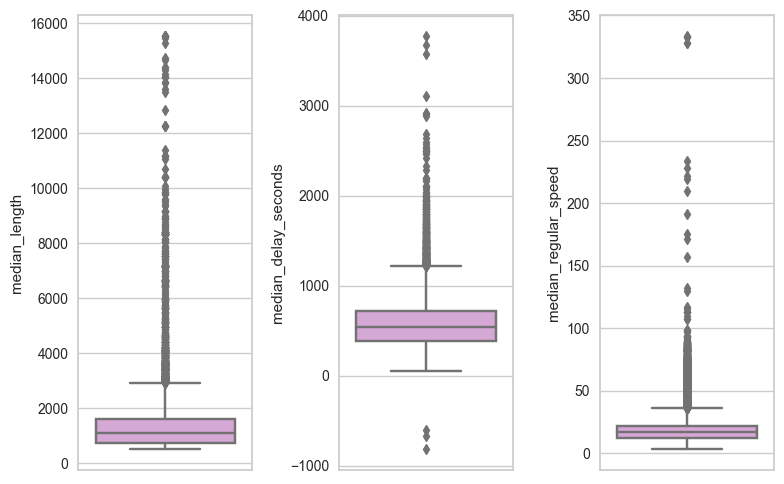

In [37]:
# Checking outlier again
plt.figure(figsize=(8,5))

numerical1 = ['median_length', 'median_delay_seconds', 'median_regular_speed']
# plotting
features = numerical1
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color='plum')
    plt.tight_layout()

Observasi :
- Ketiga feature mengandung outliers, namun tidak ada outliers yang extreme. Maka outliers tidak perlu dihapus karena dapat mengandung informasi yang diperlukan

# 5. Modeling

### A. Elbow Method

In [10]:
scaler = StandardScaler()
scaler.fit(df)
X_std = scaler.transform(df)

new_df = pd.DataFrame(data = X_std, columns = list(df))
new_df.head()

,median_length,median_delay_seconds,median_regular_speed
0,-0.442642,0.770684,2.852616
1,0.249399,1.597265,2.862455
2,0.468519,-0.606390,2.867990
3,0.409352,2.287486,-0.838687
4,-0.574032,0.654525,-0.914936


In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3) ## Jumlah Featurenya
pca.fit(X_std)
pcs = pca.transform(X_std)

In [12]:
pdf = pd.DataFrame(data = pcs)
pdf.head()

,0,1,2
0,1.648219,0.793021,2.362583
1,2.342159,-0.030126,2.306618
2,2.044573,1.827042,1.137639
3,0.251777,-2.439299,0.299973
4,-0.870387,-0.906166,0.127724


In [13]:
print('Explained variance:', pca.explained_variance_)
print('Explained variance ratio:', pca.explained_variance_ratio_*100)

Explained variance: [1.43080783 1.14489179 0.42450931]
Explained variance ratio: [47.69027304 38.16040194 14.14932502]


In [14]:
from sklearn.cluster import KMeans

inertia4 = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(pdf.values)
    nilai_inertia = kmeans.inertia_
    print('cluster: ', i, 'nilai inertia: ', nilai_inertia)
    inertia4.append(kmeans.inertia_)

cluster:  2 nilai inertia:  28489.764353484254
cluster:  3 nilai inertia:  21193.762130234732
cluster:  4 nilai inertia:  16397.794182975027
cluster:  5 nilai inertia:  13970.481043262667
cluster:  6 nilai inertia:  12289.772701479018
cluster:  7 nilai inertia:  11113.840345799274
cluster:  8 nilai inertia:  10071.406560742518
cluster:  9 nilai inertia:  9267.782337257566
cluster:  10 nilai inertia:  8574.521055309717


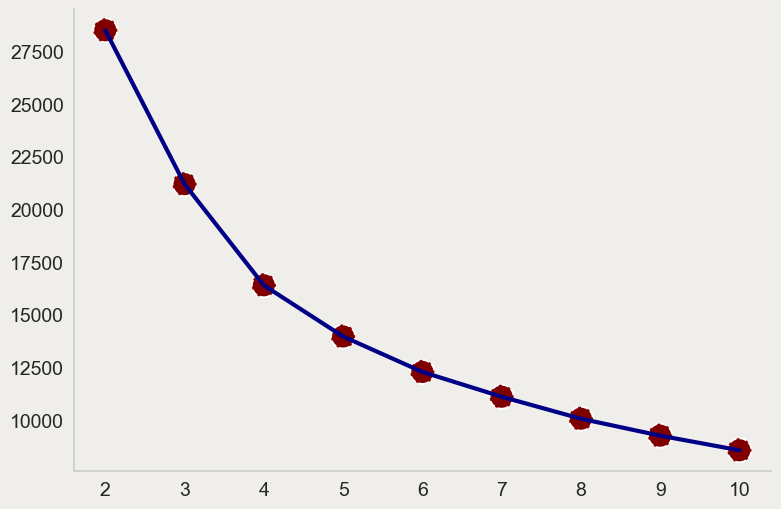

In [15]:
plt.figure(figsize=(9, 6), facecolor='#f0eeeb')

ax = sns.lineplot(x=range(2, 11), y=inertia4, color='#000087', linewidth = 3)
ax = sns.scatterplot(x=range(2, 11), y=inertia4, s=300, color='#800000',  linestyle='--')
ax.grid(False)
ax.set_facecolor('#f0eeeb')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='both', labelsize=14)

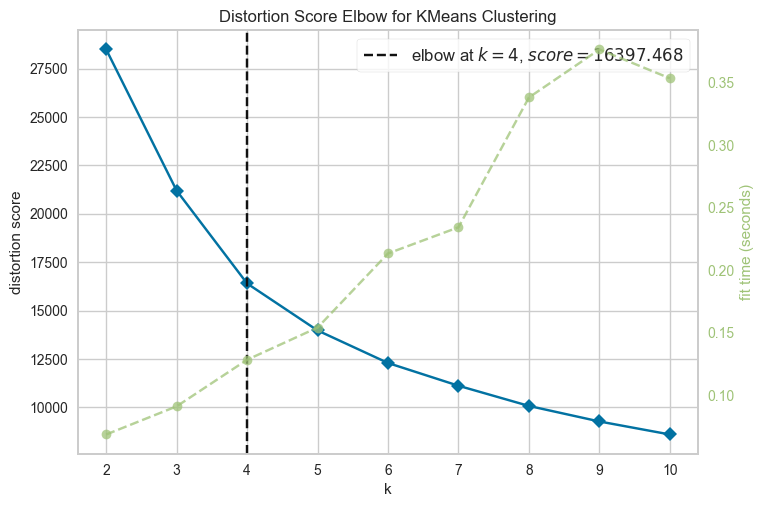

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(pdf)
elbow.show()

### B. Silhouette Score

In [17]:
range_n_clusters = list(range(2,11))

arr_silhouette_score_euclidean4 = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(pdf)
    preds4 = kmeans.predict(pdf)
     
    score_euclidean4 = silhouette_score(pdf, preds4, metric='euclidean')
    arr_silhouette_score_euclidean4.append(score_euclidean4)
    print('cluster: ', i, 'nilai euclidean: ', score_euclidean4)

cluster:  2 nilai euclidean:  0.6659922067342606
cluster:  3 nilai euclidean:  0.3777176624701443
cluster:  4 nilai euclidean:  0.39339010209603514
cluster:  5 nilai euclidean:  0.31132595367794474
cluster:  6 nilai euclidean:  0.3140727595214407
cluster:  7 nilai euclidean:  0.3096519228548183
cluster:  8 nilai euclidean:  0.30770901956382285
cluster:  9 nilai euclidean:  0.29559199487690724
cluster:  10 nilai euclidean:  0.2924321446618977


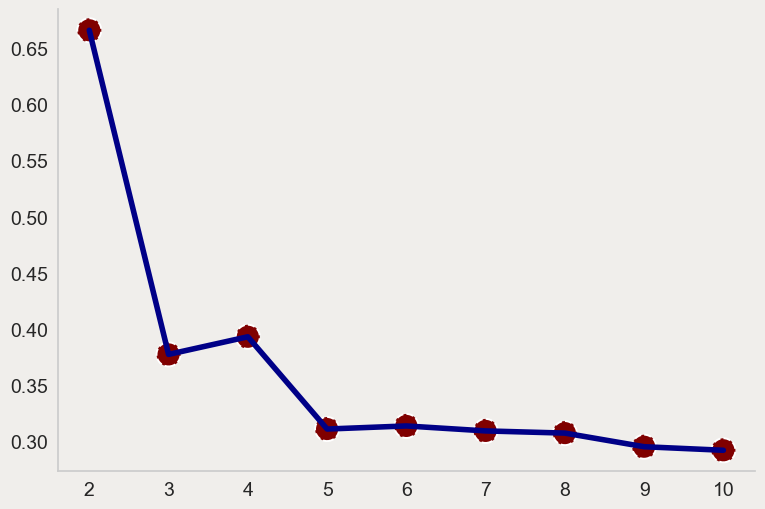

In [18]:
fig, ax = plt.subplots(figsize=(9, 6), facecolor='#f0eeeb')
ax = sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean4, color='#000087', linewidth = 4)
ax = sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean4, s=300, color='#800000',  linestyle='--')
ax.grid(False)
ax.set_facecolor('#f0eeeb')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='both', labelsize=14)

Ditentukan untuk menggunakan 2 cluster saja

In [45]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(pdf.values)

KMeans(n_clusters=2, random_state=0)

In [47]:
pdf_cluster = pdf.copy()
pdf_cluster['cluster'] = kmeans.labels_
pdf_cluster.head()

,0,1,2,cluster
0,1.648219,0.793021,2.362583,0
1,2.342159,-0.030126,2.306618,0
2,2.044573,1.827042,1.137639,0
3,0.251777,-2.439299,0.299973,1
4,-0.870387,-0.906166,0.127724,1


In [48]:
df_cluster = med_irregularities_bekasi.copy()
df_cluster['cluster'] = kmeans.labels_
df_cluster.head()

,time,street,jam_level,median_length,median_delay_seconds,median_regular_speed,total_records,median_seconds,median_speed,median_jam_level,cluster
0,2022-07-06 00:00:00,Tol Cikampek (Cikunir-Cikarang),4,869.0,803.5,67.32000,38,674.0,4.355000,4.0,0
1,2022-07-06 01:00:00,Tol Cikampek (Cikunir-Cikarang),4,1717.0,1049.0,67.48000,12,1135.0,5.475000,4.0,0
2,2022-07-06 01:00:00,Tol Cikampek (Cikunir-Cikarang),3,1985.5,394.5,67.57001,10,494.0,14.075001,3.0,0
3,2022-07-06 06:00:00,Wibawa Mukti 2,4,1913.0,1254.0,7.29000,11,1486.0,4.970000,4.0,1
4,2022-07-06 06:00:00,Cipendawa Baru,4,708.0,769.0,6.05000,5,852.0,2.960000,4.0,1


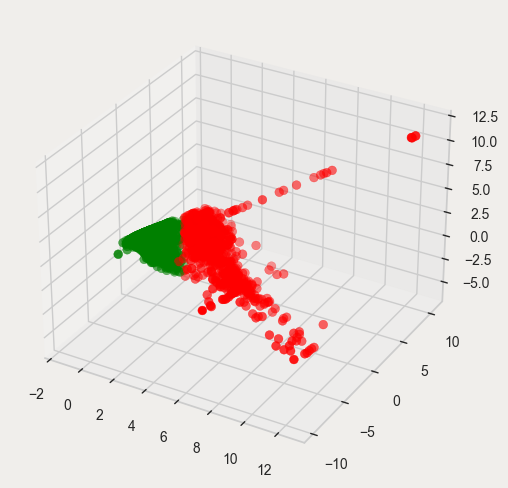

In [49]:
from matplotlib.colors import ListedColormap
from matplotlib import colors
cmap = colors.ListedColormap(["Red", "Green"])

x = pdf_cluster[0]
y = pdf_cluster[1]
z = pdf_cluster[2]
fig = plt.figure(figsize=(9,6), facecolor='#f0eeeb')
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x,y,z, s=40, c=pdf_cluster['cluster'], marker='o', cmap = cmap, label = 'cluster')
ax.set_facecolor('#f0eeeb')
plt.show()

# 6. Profiling

<AxesSubplot: xlabel='jam_level', ylabel='count'>

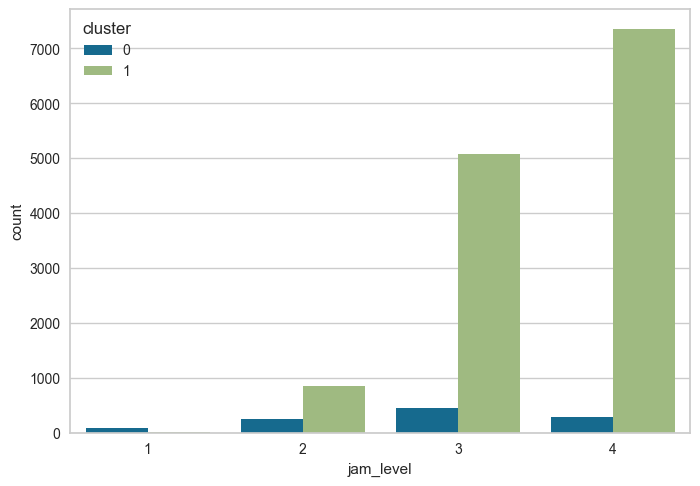

In [50]:
sns.countplot(data = df_cluster, x = 'jam_level', hue = 'cluster')

<AxesSubplot: xlabel='median_length', ylabel='Count'>

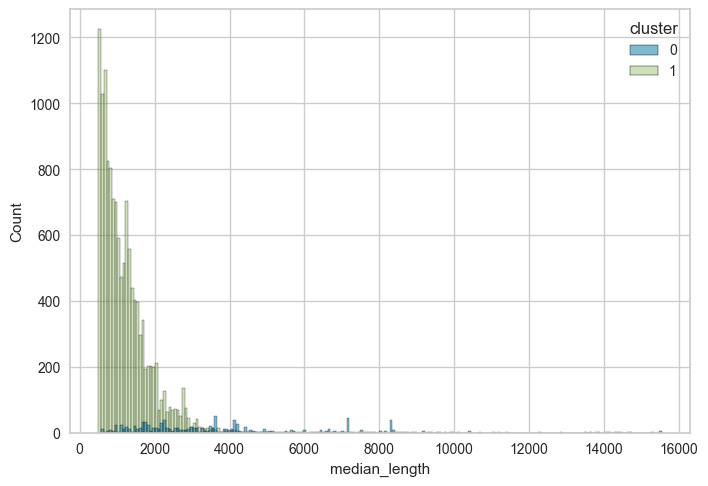

In [51]:
sns.histplot(data = df_cluster, x = 'median_length', hue = 'cluster')

<AxesSubplot: xlabel='median_delay_seconds', ylabel='Count'>

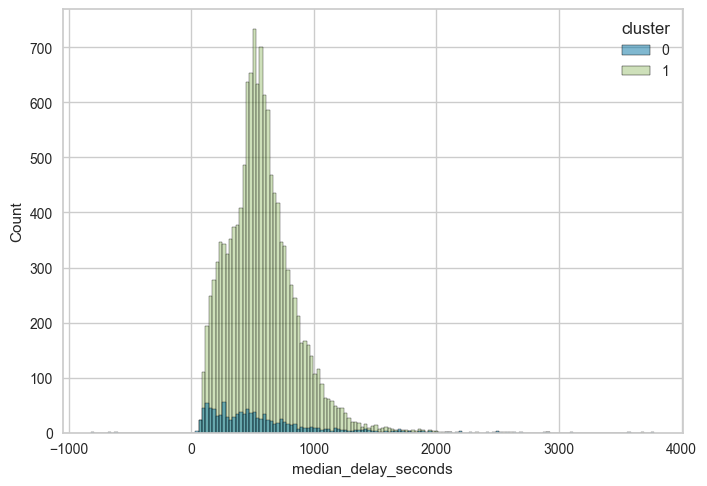

In [25]:
sns.histplot(data = df_cluster, x = 'median_delay_seconds', hue = 'cluster')

<AxesSubplot: xlabel='median_regular_speed', ylabel='Count'>

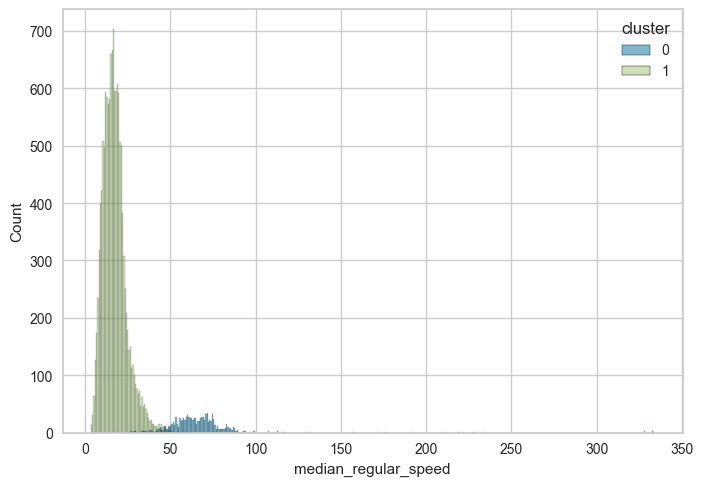

In [26]:
sns.histplot(data = df_cluster, x = 'median_regular_speed', hue = 'cluster')

### Observasi :

- Kelompok 0 dominan memiliki level kemacetan yang lebih rendah dari pada Kelompok 1
- Kelompok 0 memiliki jarak kemacetan yang relatif lebih panjang dari Kelompok 1
- Kelompok 0 memiliki penundaan kemacetan (detik) yang lebih rendah dari pada dengan Kelompok 1
- Kelompok 0 lebih memiliki median kecepatan reguler yang lebih tinggi daripada Kelompok 1

# 7. Kesimpulan

- Kelompok 0 : Kemacetan volume rendah
- Kelompok 1 : Kemacetan voulme tinggi